In [1]:
import numpy as np
import matplotlib
import snorkel

# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

In [3]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3)

In [5]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=knn,

  X_training=X_train,
  y_training=y_train,

  query_strategy=preset_batch
)

In [6]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

In [7]:
unqueried_score

0.3333333333333333

In [8]:
def random_labels(y, fraction_of_random_labels=0.10, cardinality=3):
    mask = np.random.rand(*y.shape) < fraction_of_random_labels
    r = np.random.randint(0, 3, size = y.shape)
    y[mask] = r[mask]   
    return y

def fake_multi_user_labeling(y, n_labelers, only_zeroes_idx, fraction_of_random_labels=0.10, cardinality=3):
    y = np.tile(y, (n_labelers, 1)).transpose()
    y = random_labels(y, fraction_of_random_labels, cardinality)
    if only_zeroes_idx is not None:
        y[:,only_zeroes_idx] = 0
    return(y)

In [9]:
from snorkel.labeling import LabelModel, MajorityLabelVoter, RandomVoter

In [10]:
# Pool-based sampling
N_RAW_SAMPLES = 60
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

label_model = LabelModel(cardinality=3, verbose=True)
performance_history = [unqueried_score]
X_queried, y_queried = np.ndarray([]), np.ndarray([])


for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    y = fake_multi_user_labeling(y, n_labelers = 3, only_zeroes_idx = 0)
    
    X_queried = np.append(X_queried, X, axis=0) if index>0 else X
    y_queried = np.append(y_queried, y, axis=0) if index>0 else y

    label_model.fit(L_train=y_queried, n_epochs=1000, lr=0.001, log_freq=100, seed=123)
    preds_queried = label_model.predict(L=y_queried)
    
    #y = np.mean(y, axis=1)
    #y = np.round(y)
    
    learner.teach(X=X_queried, y=preds_queried, only_new=True)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.3333
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.6667
Accuracy after query 4: 0.9067
Accuracy after query 5: 0.9267
Accuracy after query 6: 0.9600
Accuracy after query 7: 0.9600
Accuracy after query 8: 0.9733
Accuracy after query 9: 0.9733
Accuracy after query 10: 0.9733
Accuracy after query 11: 0.9533
Accuracy after query 12: 0.9467
Accuracy after query 13: 0.9667
Accuracy after query 14: 0.9667
Accuracy after query 15: 0.9467
Accuracy after query 16: 0.9467
Accuracy after query 17: 0.9600
Accuracy after query 18: 0.9600
Accuracy after query 19: 0.9600
Accuracy after query 20: 0.9600


In [11]:
%matplotlib inline

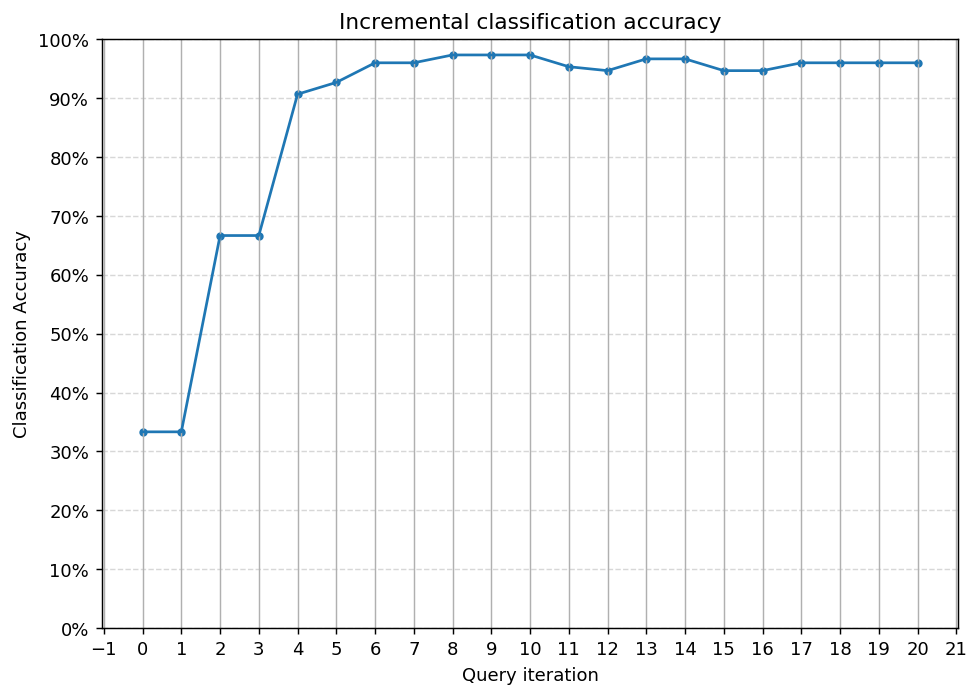

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()